In [1]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from sklearn.utils.class_weight import compute_class_weight

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.17.0


In [2]:
# 1) PATHS & SETTINGS

DATA_ROOT = r"C:\Users\Anu\Desktop\RESEARCH\data" 

train_dir = os.path.join(DATA_ROOT, "train")
val_dir   = os.path.join(DATA_ROOT, "val")
test_dir  = os.path.join(DATA_ROOT, "test")
auto_test_dir = os.path.join(DATA_ROOT, "auto_test")

IMG_SIZE = (224, 224) 
BATCH_SIZE = 32
NUM_CLASSES = 5

In [3]:
# 2) DATA LOAD (GENERATORS)

train_datagen = ImageDataGenerator(
    preprocessing_function=densenet_preprocess,
    rotation_range=5,
    width_shift_range=0.03,
    height_shift_range=0.03,
    zoom_range=0.05,
    brightness_range=(0.95, 1.05),
    horizontal_flip=False,
    fill_mode="nearest"
)

val_test_datagen = ImageDataGenerator(
    preprocessing_function=densenet_preprocess
)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=True
)

val_gen = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False
)

test_gen = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False
)

auto_test_gen = val_test_datagen.flow_from_directory(
    auto_test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False
)

print("Class mapping:", train_gen.class_indices)



Found 5778 images belonging to 5 classes.
Found 826 images belonging to 5 classes.
Found 1656 images belonging to 5 classes.
Found 1526 images belonging to 5 classes.
Class mapping: {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}


In [4]:
# 3) CLASS WEIGHTS (IMBALANCE)

train_labels = train_gen.classes

balanced_weights_arr = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_labels),
    y=train_labels
)
balanced_weights = dict(enumerate(balanced_weights_arr))
print("Balanced class weights:", balanced_weights)

# Mild boost for grade 1 & 2 (your hardest grades)
boost = {0: 1.0, 1: 1.15, 2: 1.10, 3: 1.0, 4: 1.0}


class_weights = {}
for k, v in balanced_weights.items():
    class_weights[k] = float(v) * boost.get(k, 1.0)

print("Adjusted class weights:", class_weights)


Balanced class weights: {0: 0.5055118110236221, 1: 1.1047801147227534, 2: 0.7622691292875989, 3: 1.5265521796565389, 4: 6.679768786127168}
Adjusted class weights: {0: 0.5055118110236221, 1: 1.2704971319311662, 2: 0.8384960422163589, 3: 1.5265521796565389, 4: 6.679768786127168}


In [5]:
# Focal Loss

def sparse_focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        y_true = tf.cast(tf.reshape(y_true, [-1]), tf.int32)
        y_true_oh = tf.one_hot(y_true, depth=tf.shape(y_pred)[-1])
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
        ce = -y_true_oh * tf.math.log(y_pred)
        weight = alpha * tf.pow(1 - y_pred, gamma)
        fl = weight * ce
        return tf.reduce_sum(fl, axis=-1)
    return loss


In [6]:
# 4) CHECKPOINTS + LOGGING

CHECKPOINT_DIR = "checkpoints_densenet121"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

best_model_path = os.path.join(CHECKPOINT_DIR, "densenet121_best.keras")
last_model_path = os.path.join(CHECKPOINT_DIR, "densenet121_last.keras")
log_path = os.path.join(CHECKPOINT_DIR, "densenet121_log.csv")

callbacks = [
    ModelCheckpoint(best_model_path, monitor="val_loss", save_best_only=True),
    ModelCheckpoint(last_model_path, monitor="val_loss", save_best_only=False),
    EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.3, min_lr=1e-7),
    CSVLogger(log_path, append=True)
]


In [7]:
# 5) RESUME TRAINING (IF LAST EXISTS)

if os.path.exists(last_model_path):
    print(f"\n Found last checkpoint: {last_model_path}")
    print("Loading last model to resume...")
    densenet_model = tf.keras.models.load_model(last_model_path)
else:
    print("\n No checkpoint found. Creating new DenseNet121 model...")

    base_model = DenseNet121(
        include_top=False,
        weights="imagenet",
        input_shape=IMG_SIZE + (3,)
    )
    base_model.trainable = False  # Phase 1 freeze

    inputs = layers.Input(shape=IMG_SIZE + (3,))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.45)(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

    densenet_model = models.Model(inputs, outputs)


 Found last checkpoint: checkpoints_densenet121\densenet121_last.keras
Loading last model to resume...


In [8]:
# 6) COMPILE (PHASE 1)

densenet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [9]:
# 7) PHASE 1 TRAIN (FROZEN)

EPOCHS_PHASE1 = 50

history_phase1 = densenet_model.fit(
    train_gen,
    epochs=EPOCHS_PHASE1,
    validation_data=val_gen,
    class_weight=class_weights,
    callbacks=callbacks
)


Epoch 1/50


C:\Users\Anu\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


181/181 ━━━━━━━━━━━━━━━━━━━━ 625s 3s/step - accuracy: 0.4957 - loss: 1.0611 - val_accuracy: 0.5533 - val_loss: 1.0068 - learning_rate: 1.0000e-04
Epoch 2/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 540s 3s/step - accuracy: 0.5386 - loss: 0.9003 - val_accuracy: 0.5545 - val_loss: 1.0249 - learning_rate: 1.0000e-04
Epoch 3/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 536s 3s/step - accuracy: 0.5630 - loss: 0.8363 - val_accuracy: 0.4746 - val_loss: 1.1105 - learning_rate: 1.0000e-04
Epoch 4/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 540s 3s/step - accuracy: 0.5884 - loss: 0.7606 - val_accuracy: 0.5484 - val_loss: 0.9980 - learning_rate: 1.0000e-04
Epoch 5/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 542s 3s/step - accuracy: 0.6242 - loss: 0.7100 - val_accuracy: 0.5763 - val_loss: 0.9858 - learning_rate: 1.0000e-04
Epoch 6/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 544s 3s/step - accuracy: 0.6584 - loss: 0.6788 - val_accuracy: 0.5751 - val_loss: 1.0335 - learning_rate: 1.0000e-04
Epoch 7/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 543s 3s/step - accuracy: 0.68

In [17]:
phase1_train_acc = history_phase1.history["accuracy"][-1] * 100
print(f"Phase 1 Final Training Accuracy: {phase1_train_acc:.2f}%")

phase1_val_acc = history_phase1.history["val_accuracy"][-1] * 100
print(f"Phase 1 Final Validation Accuracy: {phase1_val_acc:.2f}%")


Phase 1 Final Training Accuracy: 78.70%
Phase 1 Final Validation Accuracy: 59.32%


In [23]:
# 8) PHASE 2 FINE-TUNING

base_model = None
for layer in densenet_model.layers:
    if isinstance(layer, tf.keras.Model) and "densenet" in layer.name.lower():
        base_model = layer
        break

if base_model is None:
    print("Could not detect DenseNet base model layer. Skipping fine-tuning.")
else:
    train_last_n = 200

for l in base_model.layers[:-train_last_n]:
    l.trainable = False
for l in base_model.layers[-train_last_n:]:
    l.trainable = True

densenet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=sparse_focal_loss(gamma=2.0, alpha=0.25),
    metrics=["accuracy"]
)
    
EPOCHS_PHASE2 = 25

history_phase2 = densenet_model.fit(
    train_gen,
    epochs=EPOCHS_PHASE1 + EPOCHS_PHASE2,
    initial_epoch=EPOCHS_PHASE1,
    validation_data=val_gen,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 51/75
181/181 ━━━━━━━━━━━━━━━━━━━━ 828s 4s/step - accuracy: 0.6158 - loss: 0.1009 - val_accuracy: 0.5387 - val_loss: 0.1444 - learning_rate: 1.0000e-05
Epoch 52/75
181/181 ━━━━━━━━━━━━━━━━━━━━ 797s 4s/step - accuracy: 0.6265 - loss: 0.0903 - val_accuracy: 0.5448 - val_loss: 0.1453 - learning_rate: 1.0000e-05
Epoch 53/75
181/181 ━━━━━━━━━━━━━━━━━━━━ 988s 5s/step - accuracy: 0.6306 - loss: 0.0863 - val_accuracy: 0.5690 - val_loss: 0.1404 - learning_rate: 1.0000e-05
Epoch 54/75
181/181 ━━━━━━━━━━━━━━━━━━━━ 904s 5s/step - accuracy: 0.6448 - loss: 0.0797 - val_accuracy: 0.5690 - val_loss: 0.1385 - learning_rate: 1.0000e-05
Epoch 55/75
181/181 ━━━━━━━━━━━━━━━━━━━━ 828s 5s/step - accuracy: 0.6508 - loss: 0.0750 - val_accuracy: 0.5557 - val_loss: 0.1355 - learning_rate: 1.0000e-05
Epoch 56/75
181/181 ━━━━━━━━━━━━━━━━━━━━ 758s 4s/step - accuracy: 0.6548 - loss: 0.0736 - val_accuracy: 0.5605 - val_loss: 0.1350 - learning_rate: 1.0000e-05
Epoch 57/75
181/181 ━━━━━━━━━━━━━━━━━━━━ 800s 4s/ste

In [25]:
phase2_train_acc = history_phase2.history["accuracy"][-1] * 100
print(f"Phase 2 Final Training Accuracy: {phase2_train_acc:.2f}%")

phase2_val_acc = history_phase2.history["val_accuracy"][-1] * 100
print(f"Phase 2 Final Validation Accuracy: {phase2_val_acc:.2f}%")


Phase 2 Final Training Accuracy: 69.21%
Phase 2 Final Validation Accuracy: 56.17%


52/52 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step

DenseNet121 | TEST Exact Accuracy: 58.70%
DenseNet121 | TEST Within-1 Accuracy: 93.66%

=== DenseNet121 | TEST Classification Report ===
              precision    recall  f1-score   support

           0     0.7231    0.6823    0.7021       639
           1     0.2803    0.4527    0.3463       296
           2     0.6388    0.4787    0.5473       447
           3     0.7727    0.6861    0.7268       223
           4     0.8333    0.6863    0.7527        51

    accuracy                         0.5870      1656
   macro avg     0.6497    0.5972    0.6150      1656
weighted avg     0.6313    0.5870    0.6016      1656



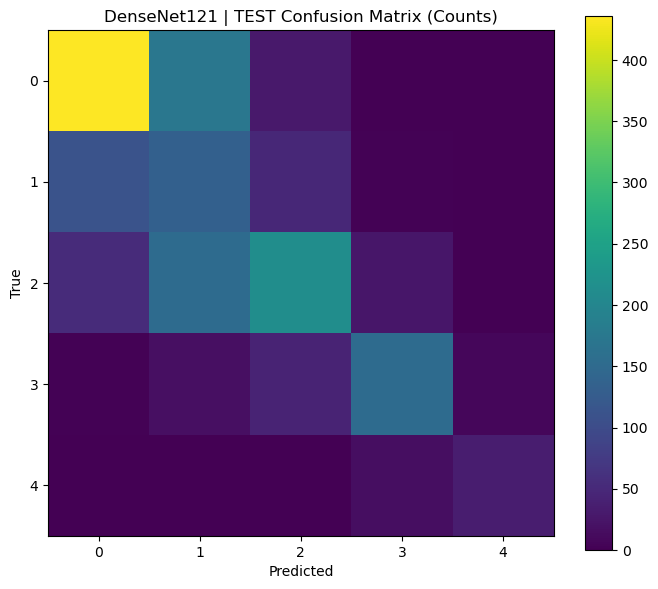

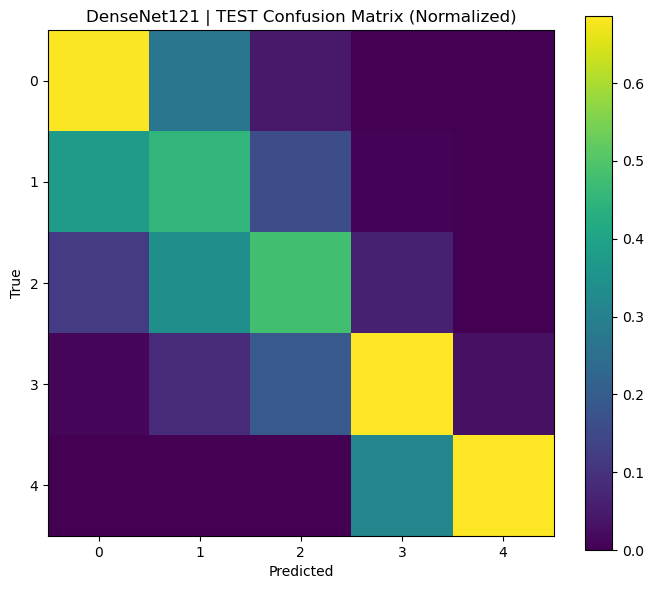

48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step

DenseNet121 | AUTO_TEST Exact Accuracy: 57.54%
DenseNet121 | AUTO_TEST Within-1 Accuracy: 94.43%

=== DenseNet121 | AUTO_TEST Classification Report ===
              precision    recall  f1-score   support

           0     0.7226    0.6556    0.6875       604
           1     0.2626    0.4545    0.3329       275
           2     0.6382    0.4640    0.5374       403
           3     0.8144    0.6800    0.7411       200
           4     0.8095    0.7727    0.7907        44

    accuracy                         0.5754      1526
   macro avg     0.6495    0.6054    0.6179      1526
weighted avg     0.6320    0.5754    0.5940      1526



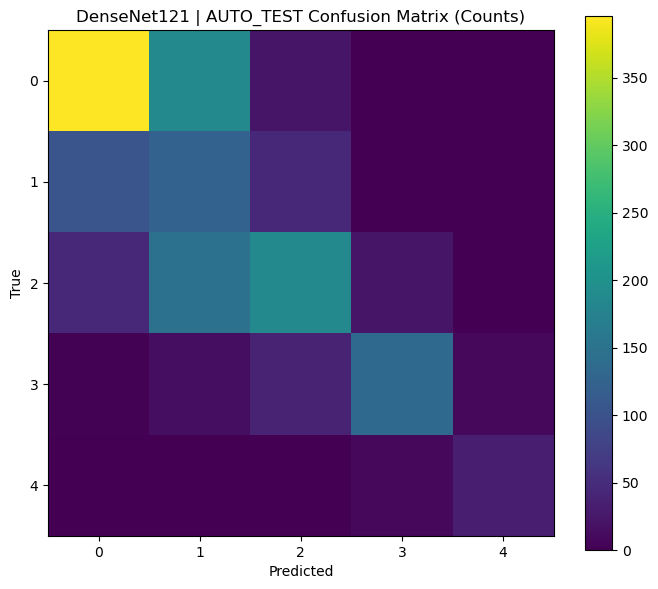

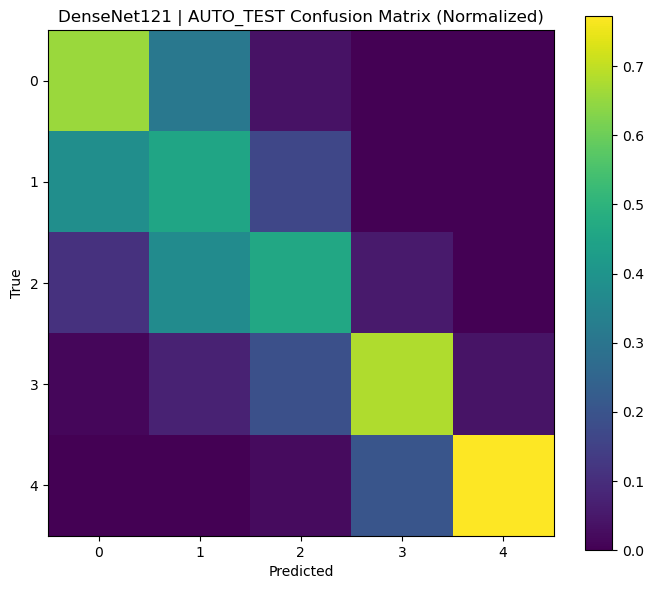

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def within_one_accuracy(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred) <= 1)

def evaluate_full(model, gen, title="TEST"):
    gen.reset()
    probs = model.predict(gen, verbose=1)
    y_pred = np.argmax(probs, axis=1)
    y_true = gen.classes

    idx_to_class = {v: k for k, v in gen.class_indices.items()}
    class_names = [idx_to_class[i] for i in range(len(idx_to_class))]

    exact_acc = np.mean(y_pred == y_true) * 100
    w1_acc = within_one_accuracy(y_true, y_pred) * 100

    print(f"\n{title} Exact Accuracy: {exact_acc:.2f}%")
    print(f"{title} Within-1 Accuracy: {w1_acc:.2f}%")

    print(f"\n=== {title} Classification Report ===")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(7,6))
    plt.imshow(cm, interpolation="nearest")
    plt.title(f"{title} Confusion Matrix (Counts)")
    plt.colorbar()
    ticks = np.arange(len(class_names))
    plt.xticks(ticks, class_names)
    plt.yticks(ticks, class_names)
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

    plt.figure(figsize=(7,6))
    plt.imshow(cm_norm, interpolation="nearest")
    plt.title(f"{title} Confusion Matrix (Normalized)")
    plt.colorbar()
    plt.xticks(ticks, class_names)
    plt.yticks(ticks, class_names)
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.tight_layout()
    plt.show()

# Run
evaluate_full(densenet_model, test_gen, "DenseNet121 | TEST")
evaluate_full(densenet_model, auto_test_gen, "DenseNet121 | AUTO_TEST")


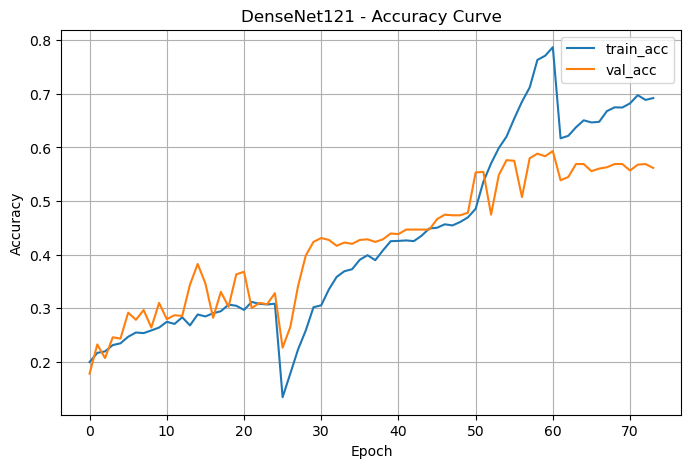

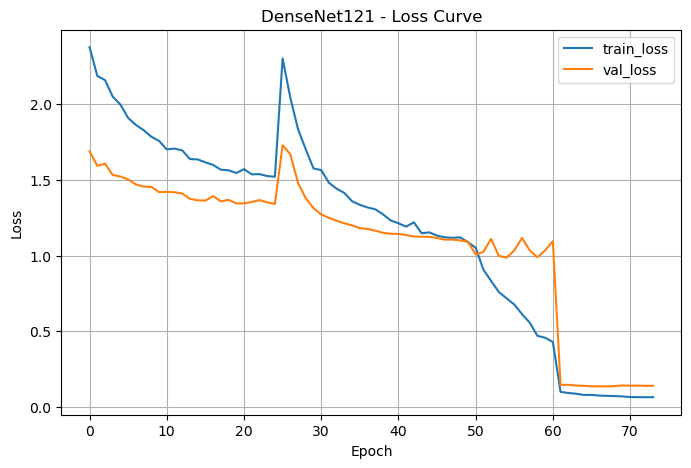

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("checkpoints_densenet121/densenet121_log.csv")

plt.figure(figsize=(8,5))
plt.plot(df["accuracy"], label="train_acc")
plt.plot(df["val_accuracy"], label="val_acc")
plt.title("DenseNet121 - Accuracy Curve")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.legend(); plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(df["loss"], label="train_loss")
plt.plot(df["val_loss"], label="val_loss")
plt.title("DenseNet121 - Loss Curve")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.grid(True)
plt.show()


In [32]:
# 10) SAVE FINAL MODEL

densenet_model.save("densenet121_final.keras")

print("\n Saved:")
print("BEST :", best_model_path)
print("LAST :", last_model_path)
print("LOG  :", log_path)
print("FINAL: densenet121_final.keras")


 Saved:
BEST : checkpoints_densenet121\densenet121_best.keras
LAST : checkpoints_densenet121\densenet121_last.keras
LOG  : checkpoints_densenet121\densenet121_log.csv
FINAL: densenet121_final.keras
